In [3]:
# schiller test --> iodine that stains different on abnormal cells on cervix
# hinsellman --> coloscopy using scope on cervix
# cytology --> pap smear
# biopsy --> biopsy 
# These indicate the RESULTS of these tests, assuming they were carried out. 1 means suspect screening, 0 means okay screening. 

# dx columns mean previous cervical diagnosis 
# stds_number is the sum over all std columns
# Cant figure out what stds_n_diagnosis is, though. 

In [4]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.impute import MissingIndicator, SimpleImputer
import matplotlib.pyplot as plt
import miceforest as mf
from miceforest import mean_match_default
import seaborn as sns
from lightgbm import LGBMClassifier
import inspect 
import warnings
import scipy.stats as stats
from tempfile import mkdtemp
from shutil import rmtree
from mice_imputer import *

In [5]:
df = pd.read_csv("./data.csv")

# Encode missings

In [6]:
df = df.replace({"?": pd.NA})

# Rename columns to be more manageable

In [7]:
df.columns.values

array(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)',
       'Smokes (packs/year)', 'Hormonal Contraceptives',
       'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs',
       'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis',
       'STDs: Time since last diagnosis', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV',
       'Dx', 'Hinselmann', 'Schiller', 'Citology', 'Biopsy'], dtype=object)

In [8]:
new_names = df.columns 
to_rep = {
    "Number" : "n",
    "Contraceptives" : "bc", 
    "Num" : "n",
    "-" : "_",
    "of" : "",
    " " : "_", 
    "(" : "",
    ")" : "",
    "/" : "_",
    ":" : "_", 
    "__" : "_"

}

for key, value in to_rep.items(): 
    new_names = new_names.str.replace(key, value, regex = True)

new_names = new_names.str.lower()

df = df.set_axis(new_names, axis = 1)

df.columns.values


array(['age', 'n_sexual_partners', 'first_sexual_intercourse',
       'n_pregnancies', 'smokes', 'smokes_years', 'smokes_packs_year',
       'hormonal_bc', 'hormonal_bc_years', 'iud', 'iud_years', 'stds',
       'stds_number', 'stds_condylomatosis',
       'stds_cervical_condylomatosis', 'stds_vaginal_condylomatosis',
       'stds_vulvo_perineal_condylomatosis', 'stds_syphilis',
       'stds_pelvic_inflammatory_disease', 'stds_genital_herpes',
       'stds_molluscum_contagiosum', 'stds_aids', 'stds_hiv',
       'stds_hepatitis_b', 'stds_hpv', 'stds_n_diagnosis',
       'stds_time_since_first_diagnosis',
       'stds_time_since_last_diagnosis', 'dx_cancer', 'dx_cin', 'dx_hpv',
       'dx', 'hinselmann', 'schiller', 'citology', 'biopsy'], dtype=object)

In [9]:
df = df.apply(pd.to_numeric, axis = 1).convert_dtypes() # convert_dtypes not working without the apply() call. Probably due to the earlier replace statement, but fiddled for an hour and no dice.

# Verifies that the count of stds is the sum over all std columns. 

In [10]:
df[df.columns[df.columns.str.startswith("stds_")]]

,stds_number,stds_condylomatosis,stds_cervical_condylomatosis,stds_vaginal_condylomatosis,stds_vulvo_perineal_condylomatosis,stds_syphilis,stds_pelvic_inflammatory_disease,stds_genital_herpes,stds_molluscum_contagiosum,stds_aids,stds_hiv,stds_hepatitis_b,stds_hpv,stds_n_diagnosis,stds_time_since_first_diagnosis,stds_time_since_last_diagnosis
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>
854,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>
855,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>
856,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>


In [11]:
all((df[df.columns[df.columns.str.startswith("stds_")]].drop(["stds_time_since_first_diagnosis", "stds_time_since_last_diagnosis", "stds_n_diagnosis", "stds_number"], axis = 1).sum(axis = 1) == df.stds_number).dropna())

True

# Drop n_diagnosis col

In [12]:
df.drop(["stds_n_diagnosis"], axis = 1, inplace = True)

# Check missingness 

In [13]:
df.isna().mean().sort_values(ascending = False)

stds_time_since_last_diagnosis        0.917249
stds_time_since_first_diagnosis       0.917249
iud                                   0.136364
iud_years                             0.136364
hormonal_bc                           0.125874
hormonal_bc_years                     0.125874
stds_syphilis                         0.122378
stds_vulvo_perineal_condylomatosis    0.122378
stds_hpv                              0.122378
stds_hepatitis_b                      0.122378
stds_hiv                              0.122378
stds_aids                             0.122378
stds_molluscum_contagiosum            0.122378
stds_genital_herpes                   0.122378
stds_pelvic_inflammatory_disease      0.122378
stds_vaginal_condylomatosis           0.122378
stds_cervical_condylomatosis          0.122378
stds_condylomatosis                   0.122378
stds_number                           0.122378
stds                                  0.122378
n_pregnancies                         0.065268
n_sexual_part

# Drop time since std diagnoses

In [14]:
df.drop(df.columns.values[df.columns.str.startswith("stds_time")], axis = 1, inplace = True)

# Check for constant columns

In [15]:
const = df.nunique() == 1

if any(const):
    print("Deleting constant columns: {}".format(df.columns.values[const]))
    df.drop(df.columns.values[const], axis = 1, inplace = True)

Deleting constant columns: ['stds_cervical_condylomatosis' 'stds_aids']


# Iud/smoking years are always >0 if you have an IUD/smoke.

In [16]:
df.loc[(df.iud == 1) & (df.iud_years == 0)]

,age,n_sexual_partners,first_sexual_intercourse,n_pregnancies,smokes,smokes_years,smokes_packs_year,hormonal_bc,hormonal_bc_years,iud,...,stds_hepatitis_b,stds_hpv,dx_cancer,dx_cin,dx_hpv,dx,hinselmann,schiller,citology,biopsy


In [17]:
df.loc[(df.smokes == 1) & (df.smokes_years == 0)]

,age,n_sexual_partners,first_sexual_intercourse,n_pregnancies,smokes,smokes_years,smokes_packs_year,hormonal_bc,hormonal_bc_years,iud,...,stds_hepatitis_b,stds_hpv,dx_cancer,dx_cin,dx_hpv,dx,hinselmann,schiller,citology,biopsy


# PCA on STD Columns

In [18]:
stds = df[df.columns.values[df.columns.str.startswith("stds_")]].drop("stds_number", axis = 1).dropna()

In [19]:
scaler = StandardScaler()
pc = PCA()
stds_s = scaler.fit_transform(stds)
pc.fit(stds_s)

PCA()

In [20]:
eigs = pc.explained_variance_ratio_
eigs_cum = np.cumsum(eigs)
ind = [i + 1 for i in range(len(eigs))]
print(eigs_cum)

[0.21281557 0.33578793 0.43706542 0.53727932 0.6374123  0.73754528
 0.83624698 0.92480148 0.99909275 1.        ]


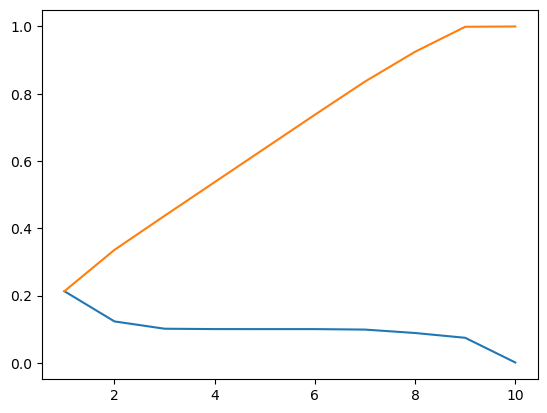

In [21]:
plt.plot(ind, eigs)
plt.plot(ind, eigs_cum)

In [22]:
pc.explained_variance_[0:3]

array([2.13098567, 1.23135892, 1.01412168])

In [23]:
loadings = pc.components_[0:3].T * np.sqrt(pc.explained_variance_[0:3])

loadmat = pd.DataFrame(np.round(loadings, 4), columns=['PC1', 'PC2', 'PC3'], index=stds.columns.values)
loadmat


,PC1,PC2,PC3
stds_condylomatosis,0.9809,-0.0569,-0.0001
stds_vaginal_condylomatosis,0.4394,-0.1656,0.1930
stds_vulvo_perineal_condylomatosis,0.9656,-0.0452,-0.0155
stds_syphilis,0.0632,0.0832,-0.8210
stds_pelvic_inflammatory_disease,-0.0179,-0.0192,0.2231
stds_genital_herpes,-0.0179,-0.0192,0.2231
stds_molluscum_contagiosum,-0.0179,-0.0192,0.2231
stds_hiv,0.1929,0.7636,-0.0030
stds_hepatitis_b,0.0230,0.7790,0.1598
stds_hpv,-0.0253,-0.0273,0.3573


# Train/Test Data

In [24]:
x = df.drop(["smokes", "hormonal_bc", "iud", "stds", "schiller", "biopsy", "hinselmann"], axis = 1)
x["n_stds"] = x["stds_number"]
x.drop(x.columns.values[x.columns.str.startswith("stds")], axis = 1, inplace = True)
y = df[["biopsy"]].astype("int64")


In [25]:
x.dtypes

age                           Int64
n_sexual_partners             Int64
first_sexual_intercourse      Int64
n_pregnancies                 Int64
smokes_years                Float64
smokes_packs_year           Float64
hormonal_bc_years           Float64
iud_years                   Float64
dx_cancer                     Int64
dx_cin                        Int64
dx_hpv                        Int64
dx                            Int64
citology                      Int64
n_stds                        Int64
dtype: object

In [26]:
x[x.select_dtypes(include=['Int64', 'Float64']).columns.values] = x.select_dtypes(include=['Int64', 'Float64']).astype('float')
x[x.columns.values[x.columns.str.startswith("dx")]] = x[x.columns.values[x.columns.str.startswith("dx")]].astype("category")
x.dtypes

age                          float64
n_sexual_partners            float64
first_sexual_intercourse     float64
n_pregnancies                float64
smokes_years                 float64
smokes_packs_year            float64
hormonal_bc_years            float64
iud_years                    float64
dx_cancer                   category
dx_cin                      category
dx_hpv                      category
dx                          category
citology                     float64
n_stds                       float64
dtype: object

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [28]:
print(y_train.shape, y_test.shape)
x_train.head()

(643, 1) (215, 1)


,age,n_sexual_partners,first_sexual_intercourse,n_pregnancies,smokes_years,smokes_packs_year,hormonal_bc_years,iud_years,dx_cancer,dx_cin,dx_hpv,dx,citology,n_stds
688,28.0,5.0,15.0,4.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
691,26.0,2.0,17.0,NaN,9.0,1.35,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
118,30.0,2.0,17.0,2.0,0.0,0.00,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168,29.0,4.0,16.0,3.0,0.0,0.00,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
347,19.0,2.0,15.0,2.0,0.0,0.00,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
if False:
    class mice_imputer(BaseEstimator, TransformerMixin):
        """
        Wrapper class for miceimputer around sklearn transformers to avoid error in miceimputer which requires the transform method to be called on the same dataset as the fit method was. This is a problem when trying to fit on a training set and 
        transform on a validation set within an sklearn pipeline that is called within gridsearchCV. 

        Pass any arguments as kwargs to this class from miceimputer's ImputationKernel() class, as well as from the ImputationKernel.mice() method. You can also pass arguments onto the underlying LightGBM implementation as keywords to mice. 
        Appropriate fit and transform methods will then be created such that the miceimputer.trasform method will work on new data. 
        """

        def __init__(self, variable_parameters=None, **kwargs):
            self.all_kwargs = kwargs
            self.lgb_args = {"num_iterations", "learning_rate", "num_leaves",
                            "max_depth", "min_data_in_leaf", "min_sum_hessian_in_leaf",
                            "bagging_fraction", "colsample_bytree", "colsample_bynode",
                            "lambda_l1", "lambda_l2", "min_split_gain", "cat_smooth"}
            self.lgb_args = self.__arg_intersect(
                self.all_kwargs, self.lgb_args, right_fn=False)
            self.inst_args = self.__arg_intersect(
                self.all_kwargs, mf.ImputationKernel)
            self.mice_args = self.__arg_intersect(
                self.all_kwargs, mf.ImputationKernel.mice)
            self.variable_parameters = variable_parameters
            self.kern = []

            self.invalid = set(self.all_kwargs.keys()).difference(set(
                self.inst_args.keys()).union(set(self.lgb_args.keys()), set(self.mice_args.keys())))

            if len(self.invalid) > 0:
                warnings.warn(
                    "Invalid **kwargs will be ignored:{}".format(self.invalid))

        def __arg_intersect(self, kwargs_dict, right, right_fn=True):
            right = inspect.getfullargspec(right).args if right_fn else right
            inter = kwargs_dict.keys() & right
            out_dict = {key: kwargs_dict[key] for key in inter}

            return out_dict

        def __warn_clean(message, category, filename, lineno, file=None, line=None):
            return ("%s:%s %s: %s\n") % (filename, lineno, category.__name__, message)
        warnings.formatwarning = __warn_clean

        def __merge_dict(self, *args):
            base = dict()
            for i in args:
                base.update(i)
            return (base)

        # Mandatory for sklearn api
        def get_params(self, deep=True):
            return self.__merge_dict(self.lgb_args, self.inst_args, self.mice_args)

        # Mandatory for sklearn api
        def set_params(self, **parameters):
            for parameter, value in parameters.items():
                setattr(self, parameter, value)
            return self

        def fit(self, X, y=None):
            """ 
            Will first instantiate miceforest.ImputationKernel with whatever keyword args that are passed to this mice_imputer class at instantiation. Afterwards, it calls ImputationKernel.mice(), again with whatever mice() kwargs were passed at 
            instantiation, which includes kwargs which are ultimately passed on to the underlying LightGBM fitter that does the imputation. 
            """
            self.kern = mf.ImputationKernel(X, save_models=2, **self.inst_args)
            self.kern.mice(variable_parameters=self.variable_parameters,
                        **self.mice_args, **self.lgb_args)
            return (self)

        def transform(self, X, y=None):
            return self.kern.impute_new_data(X, copy_data=True).complete_data(inplace=False)

        def fit_transform(self, X, y=None):
            return self.fit(X).transform(X)


In [30]:
125*(.8/.2**2)

2499.9999999999995

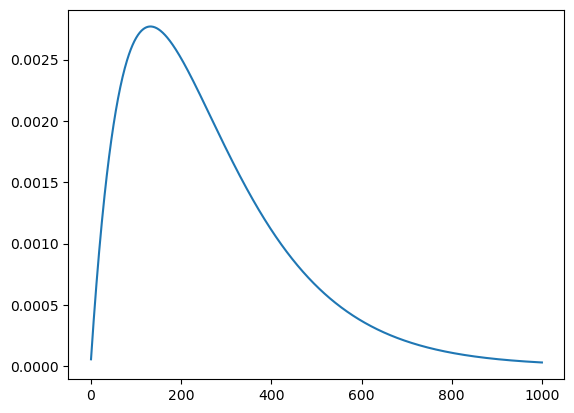

In [31]:
n = 2
p = .0075
# x = stats.nbinom.rvs(n = n, p=p, size = 10000)
# plt.hist(x,density=True, bins = 100)
xl = np.floor(np.linspace(0, 1000, 1000))
plt.plot(xl, stats.nbinom.pmf(xl, n = n, p = p))

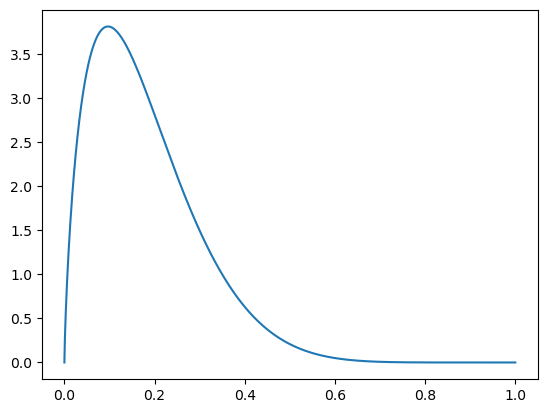

In [32]:
xl = np.linspace(0, 1, 1000)
plt.plot(xl, stats.beta.pdf(xl, 1.75, 8))

In [33]:
folds = StratifiedKFold(7, shuffle = True)

In [34]:
clf = LGBMClassifier(objective = "binary")

In [35]:
# impute_grid_poisson_template = {
#     "objective" : "poisson"
# }

# impute_grid_reg_template = {
#     "objective" : "mse"
# }

# impute_grid_pois = {}
# impute_grid_mse = {}
# keys = x.columns.values[x.isna().any()] 

# for i in keys: 

#     impute_grid_pois[i] = impute_grid_poisson_template.copy()

#     if "dx" in i: 
#         impute_grid_pois[i]["objective"] = "binary"

    

In [36]:
mean_match = mean_match_default.copy()
mean_match.set_mean_match_candidates(5)

In [37]:
grid = {
    "imputer__datasets" : stats.randint(1, 10),
    "imputer__iterations" : stats.randint(1, 12),
    "imputer__objective" : ["poisson", "mse"],
    "imputer__num_iterations" : stats.nbinom(n = 2, p = .0075),
    "imputer__learning_rate" : stats.beta(1.75, 8),
    "imputer__max_depth" : stats.randint(1, 10),
    "classifier__n_estimators" : stats.nbinom(n = 2, p = .0075),
    "classifier__max_depth" : stats.randint(1, 10),
    "classifier__learning_rate" : stats.beta(1.75, 8),
    "classifier__min_child_samples" : stats.randint(5, 50)
}

In [44]:
cache = mkdtemp()

pipe = Pipeline(
    memory = cache,
    steps = [
        ("imputer", mice_imputer(mean_match_scheme = mean_match)),
        ("classifier", clf)
    ]
)

gcv = RandomizedSearchCV(
    estimator = pipe,
    param_distributions = grid, 
    scoring = "recall",
    refit = True, 
    cv = folds,
    return_train_score = True,
    n_jobs = 18,
    n_iter = 10000
)

gcv.fit(x_train, y_train.values.flatten())
rmtree(cache)

/home/john/.conda/envs/cervical/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378 FitFailedWarning: 
7 fits failed out of a total of 70000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/home/john/.conda/envs/cervical/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/john/.conda/envs/cervical/lib/python3.10/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/john/.conda/envs/cervical/lib/python3.10/site-packages/lightgbm/sklearn.py", line 967, in f

In [46]:
gcv.best_params_

{'classifier__learning_rate': 0.40465756888172993,
 'classifier__max_depth': 2,
 'classifier__min_child_samples': 17,
 'classifier__n_estimators': 536,
 'imputer__datasets': 4,
 'imputer__iterations': 11,
 'imputer__learning_rate': 0.12471971476798172,
 'imputer__max_depth': 3,
 'imputer__num_iterations': 629,
 'imputer__objective': 'poisson'}